Como primer paso, instalamos openCV y Numpy, luego clonamos el repositorio con los archivos:

In [13]:
# Only for Collab
#!pip install numpy==1.23
#!pip install opencv-python==4.7.0.72
#!pip install rasterio

# TODO: Clone

### **Ejercicios 1 y 2:**

Cargamos una imagen de ejemplo utilizando openCV:

In [2]:
import cv2
import numpy as np

img_folder_path = './Example Landsat8/'
image = cv2.imread(f'{img_folder_path}LC08_224-078_2018-01-05_RGB.png')

In [2]:
type(image)

numpy.ndarray

In [3]:
image.dtype

dtype('uint8')

In [4]:
image.shape

(451, 1042, 3)

La mostramos:

In [3]:
# Collab Version
#from google.colab.patches import cv2_imshow
#def show_image(img):
#    cv2_imshow(img)

# Desktop Version
def show_image(img):
    cv2.imshow('image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [6]:
show_image(image)

Guardamos una copia en la misma carpeta:

In [7]:
cv2.imwrite(img_folder_path + "copy.png", image)

True

Obtenemos el valor del pixel de una imagen:

In [8]:
def get_pixel_value(img, x, y):
  return img[x, y]

In [9]:
print("Pixel (0,324): ", get_pixel_value(image, 0, 324))

Pixel (0,324):  [81 81 34]


In [10]:
print("Pixel (200,500): ", get_pixel_value(image, 200, 500))

Pixel (200,500):  [30 27 12]


Copiamos una parte de la imagen en otro archivo:

In [107]:
def crop_image(image, x1, y1, x2, y2, path=None):
  cropped = image[x1:x2, y1:y2, :].copy()
  if (path is not None) and (path != ''):
    cv2.imwrite(path, cropped)
  return cropped

In [12]:
cropped = crop_image(image, 0, 324, 200, 524, img_folder_path + "cropped.tif")

In [13]:
show_image(cropped)

### **Ejercicios 3 y 4:**

In [14]:
def get_pixels_mean_report(image, x1, y1, x2, y2):
  cropped = image[x1:x2, y1:y2, :]
  print("Número de pixels:", cropped.size)
  print("Dimensiones:", cropped.shape)
  print("Cantidad de bandas:", cropped.shape[2])
  print("Promedio de intensidad por banda:", np.mean(image, axis=(0, 1)))
  print("Promedio general de color:", np.mean(image))

In [15]:
get_pixels_mean_report(image, 0, 324, 200, 524)

Número de pixels: 120000
Dimensiones: (200, 200, 3)
Cantidad de bandas: 3
Promedio de intensidad por banda: [25.14998659 29.18185436 20.92060297]
Promedio general de color: 25.08414797287041


### Carga de imagen de Landsat8 con 7 bandas:

Para los siguientes ejercicios, definimos un mecanismo para cargar múltiples bandas en una sola matriz:

In [4]:
import os
landsat8_bands_folder = './Landsat8 - Tiff/'

def load_landsat8_band(folder_path, file):
    print("Loaded Band:", file)
    band = cv2.imread(folder_path + file)
    return band[:,:, 0]

def load_landsat8_image(folder_path, prefix, img_extension = ".tif"):
    bands = [(f.replace(img_extension, "").replace(prefix, ""), load_landsat8_band(folder_path, f)) for f in os.listdir(folder_path) if (f.startswith(prefix) and f.endswith(img_extension))]
    image = np.array([band for _,band in bands])
    bands_index = {name:index for (index, name) in enumerate([name for (name,_) in bands])}
    return image, bands_index

landsat8_image, bands_index = load_landsat8_image(landsat8_bands_folder, "LC08_224-078_2018-01-05_")

Loaded Band: LC08_224-078_2018-01-05_blue.tif
Loaded Band: LC08_224-078_2018-01-05_ca.tif
Loaded Band: LC08_224-078_2018-01-05_green.tif
Loaded Band: LC08_224-078_2018-01-05_nir.tif
Loaded Band: LC08_224-078_2018-01-05_red.tif
Loaded Band: LC08_224-078_2018-01-05_swir1.tif
Loaded Band: LC08_224-078_2018-01-05_swir2.tif


In [5]:
landsat8_image.shape

(7, 451, 1042)

In [6]:
bands_index

{'blue': 0, 'ca': 1, 'green': 2, 'nir': 3, 'red': 4, 'swir1': 5, 'swir2': 6}

In [7]:
def calculate_indexes(landsat_image, bands_index):
    nir = landsat_image[bands_index["nir"]]
    r = landsat_image[bands_index["red"]]
    g = landsat_image[bands_index["green"]]

    ndvi = np.divide(nir - r, nir + r, out=np.zeros_like(nir, dtype='float64'), where=(nir + r) != 0).astype('uint8')
    ndwi = np.divide(g - nir, g + nir, out=np.zeros_like(nir, dtype='float64'), where=(g + nir) != 0).astype('uint8')
    return ndvi, ndwi

In [8]:
ndvi, ndwi = calculate_indexes(landsat8_image, bands_index)

In [9]:
def convert_index_to_image(index):
    final_image = np.zeros((index.shape[0], index.shape[1], 3))
    for i in range(3):
        final_image[:, :, i] = index
    return final_image

In [19]:
ndvi_image = convert_index_to_image(ndvi)
show_image(ndvi_image)

In [20]:
ndwi_image = convert_index_to_image(ndwi)
show_image(ndwi_image)

### **Ejercicio 6:**

In [37]:
def gamma_correction(image, gamma, L):
    c = (L-1)**(2 - gamma) # Uso (2 - gamma) para que el valor quede entre 0 y L-1 en vez de 0 y 1
    return (c * np.power(image, gamma)).astype("uint8")

Gamma = 2

In [39]:
show_image(gamma_correction(ndvi_image, 2, 256))

Gamma = 0.7

In [40]:
show_image(gamma_correction(ndvi_image, 0.7, 256))

Gamma = 0.5

In [41]:
show_image(gamma_correction(ndvi_image, 0.5, 256))

Gamma = 0.2

In [42]:
show_image(gamma_correction(ndvi_image, 0.2, 256))

### Ejercicio 7:

In [136]:
rgb_folder_path = './Example Landsat8/'
image = cv2.imread(f'{rgb_folder_path}LC08_224-078_2018-01-05_RGB.png')
image = crop_image(image, 0, 324, 450, 717) # Recorto los bordes negros

In [182]:
def invert_color(image, band = None, max_value = 255):
    inverted_image = max_value - image
    if band is None:
        return inverted_image
    
    for i in range(image.shape[2]):
        if i != band:
            inverted_image[:, :, i] = inverted_image[:, :, band]

    #inverted_image = image.copy()
    #inverted_image[:, :, band] = max_value - image[:, :, band]

    return inverted_image

Inversión de primer banda (Azul):

In [183]:
show_image(invert_color(image, 0))

Inversión de segunda banda (Verde):

In [184]:
show_image(invert_color(image, 1))

Inversión de tercera banda (Rojo):

In [185]:
show_image(invert_color(image, 2))

Inversión de todas las bandas:

In [229]:
show_image(invert_color(image))

### **Ejercicio 8:**

In [271]:
def histogram(image, band, depth = 8):
    hist = np.zeros(2**depth)
    unique_counts = np.unique(image[:, :, band], return_counts=True)
    unique_counts = zip(unique_counts[0], unique_counts[1])
    for value,count in unique_counts:
        hist[value] = count / image[:, :, band].size

    return hist

In [277]:
hists = [histogram(image, i) for i in range(3)]

In [280]:
from matplotlib import pyplot as plt

def plot_histograms(hists, titles, main_title):
    fig, ax = plt.subplots(len(hists))
    fig.suptitle(main_title)

    for i in range(len(hists)):
        ax[i].bar(np.linspace(0, len(hists[i]) - 1, len(hists[i])), hists[i])
        ax[i].set_title(titles[i])

    fig.tight_layout(h_pad=1)
    plt.show()

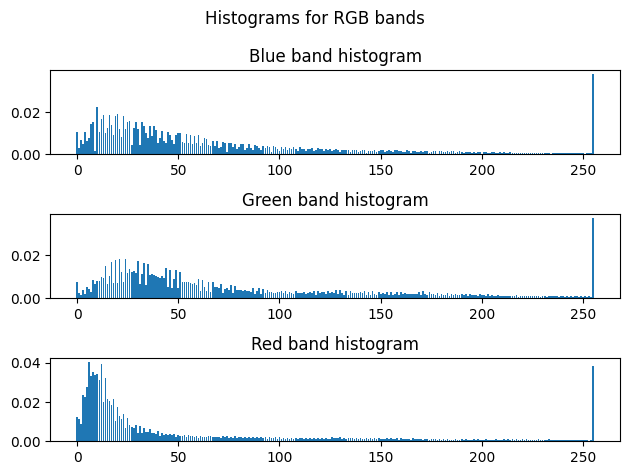

In [281]:
plot_histograms(hists, ["Blue band histogram", "Green band histogram", "Red band histogram"], "Histograms for RGB bands")

### **Ejercicio 9:**

In [238]:
def threshold(image, threshold, band, depth = 8):
    th_image = np.zeros(image.shape)
    th_image[image >= threshold] = (2**depth -1)

    for i in range(image.shape[2]):
        if i != band:
            th_image[:, :, i] = th_image[:, :, band]

    return th_image

Banda: Azul, Umbral: 127

In [242]:
show_image(threshold(image, 127, 0))

Banda: Azul, Umbral: 50

In [243]:
show_image(threshold(image, 50, 0))

Banda: Azul, Umbral: 200

In [246]:
show_image(threshold(image, 200, 0))

Banda: Verde, Umbral: 100

In [249]:
show_image(threshold(image, 100, 1))

Banda: Rojo, Umbral: Media

In [254]:
mean_value = round(np.mean(image[:, :, 2]))
mean_value

55

In [255]:
show_image(threshold(image, mean_value, 2))

### **Ejercicio 10:**

In [299]:
def histogram_equalization(image, band, depth = 8):
    hist = histogram(image, band, depth)
    max_value = 2**depth - 1
    transformed_levels = np.array([np.sum(hist[0:k]) for k in range(len(hist))]) * max_value
    transform_function = np.vectorize(lambda x: transformed_levels[x])
    return transform_function(image[:, :, band]).astype("uint" + str(depth))

In [300]:
eqs = [histogram_equalization(image, i) for i in range(3)]

In [304]:
show_image(eqs[0])

In [305]:
show_image(eqs[1])

In [306]:
show_image(eqs[2])

In [311]:
show_image(histogram_equalization(np.expand_dims(ndvi, 2), 0))